# Multiclass Classification using Keras and TensorFlow on kvasir Dataset  
![alt text](https://www.vision.ee.ethz.ch/datasets_extra/kvasir/static/img/kvasir.jpg)

**kvasir Dataset** - https://www.vision.ee.ethz.ch/datasets_extra/kvasir/




```
# This is formatted as code
```

# Download and extract KVASIR Dataset

* Add all the imports

In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
from PIL import Image
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [ ]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.4.1
/device:GPU:0


In [ ]:
# Helper function to download data and extract

def get_data_extract():
  if "kvasir-dataset" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'kvasir-dataset.zip',
    "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip",
    cache_subdir='/content',
    extract=True,
    archive_format='zip',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [ ]:
# Download data and extract it to folder
get_data_extract()

2489319424/2489312085 [==============================] - 139s 0us/step
Dataset downloaded and extracted!


In [1]:
# Rename folder
!mv kvasir-dataset-v2/ kvasir/

mv: cannot stat 'kvasir-dataset-v2/': No such file or directory


* The kvasir dataset is around 1GB in size. 



# Understand dataset structure and files 

* The dataset being used is [kvasir 101](https://www.vision.ee.ethz.ch/datasets_extra/kvasir/)
* This dataset has 101000 images in total. It's a kvasir dataset with 101 categories(multiclass)
* Each type of kvasir has 750 training samples and 250 test samples
* Note found on the webpage of the dataset :  
* On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
* The entire dataset is 5GB in size

In [ ]:
# Check the extracted dataset folder
import glob
IMG_CLASS = glob.glob("kvasir/*")
IMG_PATH = glob.glob("kvasir/*/*")

In [ ]:
len(IMG_CLASS), len(IMG_PATH)

(8, 8000)

In [ ]:
cat = {}

for c in IMG_CLASS:
  cat.update({c.split("/")[-1]:len(glob.glob(c+"/*"))})

cat

{'dyed-lifted-polyps': 1000,
 'dyed-resection-margins': 1000,
 'esophagitis': 1000,
 'normal-cecum': 1000,
 'normal-pylorus': 1000,
 'normal-z-line': 1000,
 'polyps': 1000,
 'ulcerative-colitis': 1000}

In [ ]:
cat

{'dyed-lifted-polyps': 1000,
 'dyed-resection-margins': 1000,
 'esophagitis': 1000,
 'normal-cecum': 1000,
 'normal-pylorus': 1000,
 'normal-z-line': 1000,
 'polyps': 1000,
 'ulcerative-colitis': 1000}

* **kvasir** folder contains 8 folders with 8000 images  

1.   List item
2.   List item

each. 
* Each folder contains images of a specific kvasir class.
* It's a balanced dataset, because each class has same number of images.





# Visualize random image from each of the kvasir classes

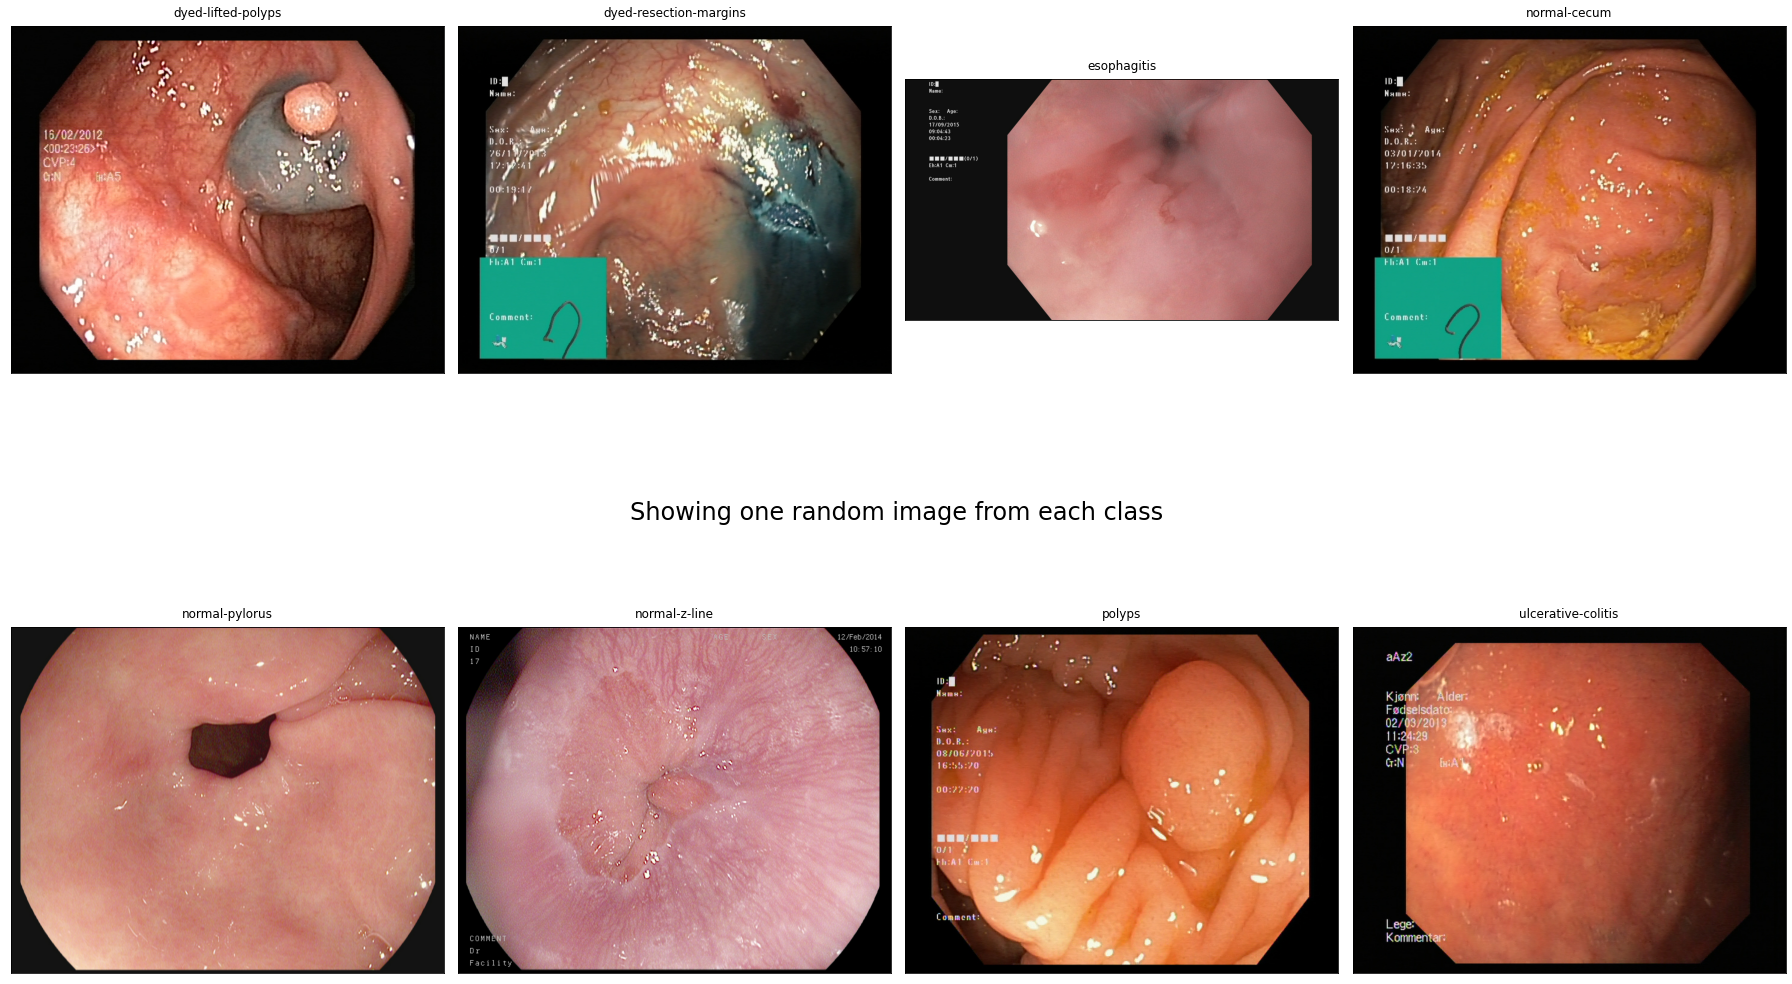

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 2
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(25,20))
fig.suptitle("Showing one random image from each class", y=0.5, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "kvasir"
kvasirs_sorted = sorted(os.listdir(data_dir))
kvasir_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      kvasir_selected = kvasirs_sorted[kvasir_id] 
      kvasir_id += 1
    except:
      break
    kvasir_selected_images = os.listdir(os.path.join(data_dir,kvasir_selected)) # returns the list of all files present in each kvasir category
    kvasir_selected_random = np.random.choice(kvasir_selected_images) # picks one kvasir item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,kvasir_selected, kvasir_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(kvasir_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


# Split the image data into train and test using train.txt and test.txt

In [ ]:
im = Image.open(IMG_PATH[0])
width, height = im.size

In [ ]:
im.size

(720, 576)

In [ ]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))
print(cwd)

Files in '/content': ['.config', 'kvasir-dataset.zip', 'kvasir', 'sample_data']
/content


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'kvasir',
  validation_split=0.01,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 7920 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'kvasir',
  validation_split=0.01,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 80 files for validation.


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Data augmentation


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

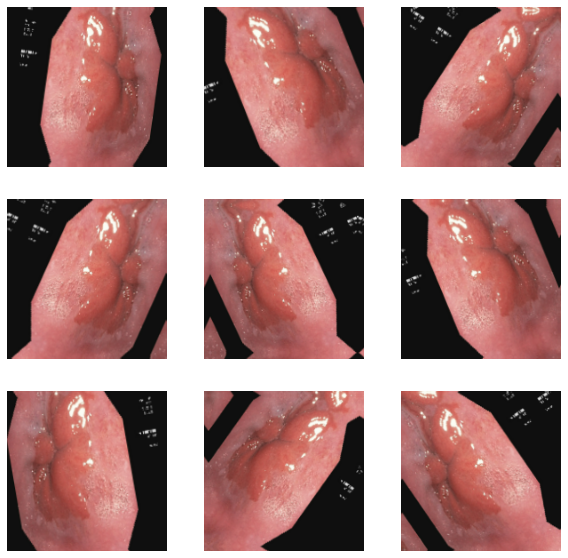

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 8

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
num_classes = 8
model = tf.keras.Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='relu')
])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 45, 45, 32)       

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.build((None, 180, 180, 3)) 
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 45, 45, 32)       

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=80
)

Epoch 1/80
248/248 [==============================] - 7s 24ms/step - loss: 1.6982 - accuracy: 0.3291 - val_loss: 1.3832 - val_accuracy: 0.5250
Epoch 2/80
248/248 [==============================] - 6s 23ms/step - loss: 1.2208 - accuracy: 0.5448 - val_loss: 1.3300 - val_accuracy: 0.5125
Epoch 3/80
248/248 [==============================] - 6s 23ms/step - loss: 1.1074 - accuracy: 0.5754 - val_loss: 1.0378 - val_accuracy: 0.5750
Epoch 4/80
248/248 [==============================] - 6s 23ms/step - loss: 0.8623 - accuracy: 0.6241 - val_loss: 1.0979 - val_accuracy: 0.5500
Epoch 5/80
248/248 [==============================] - 6s 23ms/step - loss: 0.8583 - accuracy: 0.6210 - val_loss: 0.9112 - val_accuracy: 0.5750
Epoch 6/80
248/248 [==============================] - 6s 23ms/step - loss: 0.9095 - accuracy: 0.6022 - val_loss: 0.9462 - val_accuracy: 0.5750
Epoch 7/80
248/248 [==============================] - 6s 23ms/step - loss: 0.8231 - accuracy: 0.6413 - val_loss: 0.9026 - val_accuracy: 0.5750

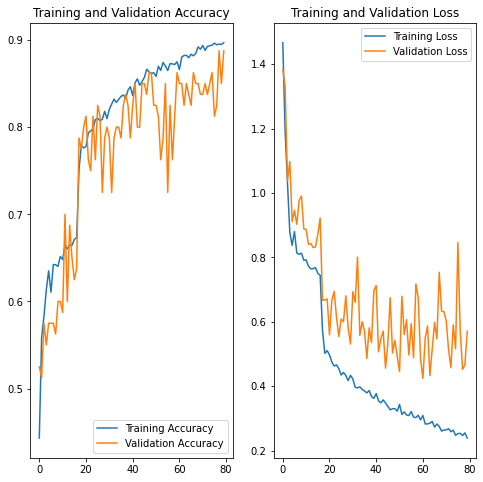

In [ ]:
epochs = 80
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Visualize the accuracy and loss plots

In [ ]:
model.save("model.hdf5")

# Predicting classes for new images from internet using the best trained model

In [ ]:
%%time
# Loading the best saved model to make predictions

model_best = load_model('model.hdf5',compile = False)

CPU times: user 287 ms, sys: 413 µs, total: 287 ms
Wall time: 290 ms


* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [ ]:
# Make a list of images and test the trained model

images = []
img_path_1 = "/content/kvasir/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg"
img_path_2 = "/content/kvasir/dyed-resection-margins/003808ff-c349-481a-9c91-e9acf1c181b7.jpg"
img_path_3 = "/content/kvasir/esophagitis/001fb927-4814-4ba5-851d-189db99291d8.jpg"
img_path_4 = "/content/kvasir/normal-cecum/00b1b20b-ce2b-449c-93fc-6df854e3ab33.jpg"
img_path_5 = "/content/kvasir/normal-pylorus/005959d0-b75b-41ed-8da1-2a5d0666d612.jpg"
img_path_6 = "/content/kvasir/normal-z-line/00bee375-36d2-4ba9-89e5-bd6132d79c0c.jpg"
img_path_7 = "/content/kvasir/polyps/00072d5f-7cd8-434c-8a5a-1a0bb2c9711d.jpg"
img_path_7 = "/content/kvasir/ulcerative-colitis/0619187d-fd10-4ac3-9a17-a70c622c3746.jpg"
images.append(img_path_1)
images.append(img_path_2)
images.append(img_path_3)
images.append(img_path_4)
images.append(img_path_5)
images.append(img_path_6)
images.append(img_path_7)





In [ ]:
img_path = img_path_1
class_names =[]
for key, value in cat.items():
    temp = [key,value]
    class_names.append(temp)
class_names.sort()
for img_path in images:
  img = keras.preprocessing.image.load_img(
      img_path, target_size=(img_height, img_width)
      )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model_best.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

This image most likely belongs to ['dyed-lifted-polyps', 1000] with a 100.00 percent confidence.
This image most likely belongs to ['dyed-lifted-polyps', 1000] with a 72.92 percent confidence.
This image most likely belongs to ['esophagitis', 1000] with a 94.58 percent confidence.
This image most likely belongs to ['normal-cecum', 1000] with a 99.09 percent confidence.
This image most likely belongs to ['normal-pylorus', 1000] with a 100.00 percent confidence.
This image most likely belongs to ['normal-z-line', 1000] with a 97.46 percent confidence.
This image most likely belongs to ['ulcerative-colitis', 1000] with a 73.41 percent confidence.


The model got them all right!